# 第15章: 動的因果効果の推定 (Estimation of Dynamic Causal Effects)

この章では、時系列データにおける動的因果効果の推定について学びます。

## 主なトピック
- 動的因果効果とは
- 分布ラグモデル（Distributed Lag Models）
- 外生性と厳密外生性
- インパルス応答関数

## 必要なパッケージ

In [1]:
# 必要なパッケージのインストールと読み込み
if (!require("AER")) install.packages("AER")
if (!require("dynlm")) install.packages("dynlm")
if (!require("lmtest")) install.packages("lmtest")
if (!require("sandwich")) install.packages("sandwich")
if (!require("vars")) install.packages("vars")

library(AER)
library(dynlm)
library(lmtest)
library(sandwich)
library(vars)

Loading required package: AER



Loading required package: car



Loading required package: carData



Loading required package: lmtest



Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Loading required package: sandwich



Loading required package: survival



Loading required package: dynlm



Loading required package: vars



Loading required package: MASS



Loading required package: strucchange



Loading required package: urca



---
## 問題1: 動的因果効果の概念

政策変数 $x_t$ がアウトカム $y_t$ に与える影響が時間を通じて広がる場合を考えます。

以下のシミュレーションでデータを生成し、動的因果効果を推定します。

```r
set.seed(123)
n <- 200
x <- rnorm(n)  # 外生的なショック
# 真の動的因果効果: 即時効果0.5, 1期ラグ0.3, 2期ラグ0.1
y <- numeric(n)
for (t in 3:n) {
  y[t] <- 0.5 * x[t] + 0.3 * x[t-1] + 0.1 * x[t-2] + rnorm(1, 0, 0.5)
}
dyn_data <- ts(cbind(y = y, x = x))
```

1. 分布ラグモデル DL(2) を推定してください
2. 推定された係数と真の値を比較してください
3. 累積乗数を計算してください

In [2]:
# ここに回答を入力してください


### 模範解答

In [3]:
# データの生成
set.seed(123)
n <- 200
x <- rnorm(n)
y <- numeric(n)
for (t in 3:n) {
  y[t] <- 0.5 * x[t] + 0.3 * x[t-1] + 0.1 * x[t-2] + rnorm(1, 0, 0.5)
}
dyn_data <- ts(cbind(y = y, x = x))

# 1. DL(2)モデルの推定
dl2_model <- dynlm(y ~ x + L(x, 1) + L(x, 2), data = dyn_data)
cat("DL(2)モデルの推定結果:\n")
summary(dl2_model)

# 2. 推定値と真の値の比較
true_values <- c(0.5, 0.3, 0.1)
estimated <- coef(dl2_model)[c("x", "L(x, 1)", "L(x, 2)")]

comparison <- data.frame(
  ラグ = c(0, 1, 2),
  真の値 = true_values,
  推定値 = estimated
)
cat("\n係数の比較:\n")
print(comparison)

# 3. 累積乗数の計算
cumulative <- cumsum(estimated)
cat("\n累積乗数:\n")
cat("0期: ", cumulative[1], "\n")
cat("1期まで:", cumulative[2], "\n")
cat("2期まで（長期乗数）:", cumulative[3], "\n")

cat("\n真の累積乗数:", cumsum(true_values), "\n")

DL(2)モデルの推定結果:



Time series regression with "ts" data:
Start = 3, End = 200

Call:
dynlm(formula = y ~ x + L(x, 1) + L(x, 2), data = dyn_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.20993 -0.33595 -0.01793  0.36169  1.20888 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.02526    0.03559   0.710   0.4787    
x            0.47913    0.03790  12.641  < 2e-16 ***
L(x, 1)      0.32157    0.03800   8.461 6.37e-15 ***
L(x, 2)      0.08134    0.03806   2.137   0.0339 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5008 on 194 degrees of freedom
Multiple R-squared:  0.5287,	Adjusted R-squared:  0.5214 
F-statistic: 72.54 on 3 and 194 DF,  p-value: < 2.2e-16



係数の比較:


        ラグ 真の値     推定値
x          0    0.5 0.47912858
L(x, 1)    1    0.3 0.32156622
L(x, 2)    2    0.1 0.08133845



累積乗数:


0期:  0.4791286 


1期まで: 0.8006948 


2期まで（長期乗数）: 0.8820332 



真の累積乗数: 0.5 0.8 0.9 


---
## 問題2: ラグ次数の選択

動的効果を推定する際、何期のラグを含めるべきかを決定する必要があります。

```r
set.seed(456)
n <- 300
x <- rnorm(n)
y <- numeric(n)
# 真のラグは3期まで
for (t in 4:n) {
  y[t] <- 0.4 * x[t] + 0.3 * x[t-1] + 0.2 * x[t-2] + 0.1 * x[t-3] + rnorm(1, 0, 0.5)
}
lag_data <- ts(cbind(y = y, x = x))
```

1. DL(1)からDL(5)まで推定し、情報量基準を比較してください
2. F検定を使ってラグの追加が有意かどうか検定してください
3. 最適なラグ次数を決定してください

In [4]:
# ここに回答を入力してください


### 模範解答

In [5]:
# データの生成
set.seed(456)
n <- 300
x <- rnorm(n)
y <- numeric(n)
for (t in 4:n) {
  y[t] <- 0.4 * x[t] + 0.3 * x[t-1] + 0.2 * x[t-2] + 0.1 * x[t-3] + rnorm(1, 0, 0.5)
}
lag_data <- ts(cbind(y = y, x = x))

# 1. 異なるラグ次数でのモデル推定
# 同じデータサイズでモデルを比較するため、最大ラグ（5）の開始点から使用
start_t <- 6  # L(x, 5)を使う場合は6期目から

results <- data.frame(ラグ次数 = 1:5, AIC = NA, BIC = NA, R2_adj = NA)

models <- list()
for (p in 1:5) {
  formula <- as.formula(paste("y ~ x +", paste(paste0("L(x, ", 1:p, ")"), collapse = " + ")))
  models[[p]] <- dynlm(formula, data = lag_data, start = start_t)
  results$AIC[p] <- AIC(models[[p]])
  results$BIC[p] <- BIC(models[[p]])
  results$R2_adj[p] <- summary(models[[p]])$adj.r.squared
}

cat("情報量基準の比較:\n")
print(results)

# 2. F検定によるラグの追加の検定
# 同じサンプルサイズで推定されているのでanova()が使用可能
cat("\nF検定によるラグの追加の検定:\n")
for (p in 2:5) {
  f_test <- anova(models[[p-1]], models[[p]])
  cat(paste("DL(", p-1, ") vs DL(", p, "): F = ", 
            round(f_test$F[2], 3), ", p値 = ", 
            round(f_test$`Pr(>F)`[2], 4), "\n", sep = ""))
}

# 3. 最適なラグ次数の決定
cat("\n最適なラグ次数:\n")
cat("AIC最小:", which.min(results$AIC), "\n")
cat("BIC最小:", which.min(results$BIC), "\n")

# 選択されたモデルの推定結果
cat("\nDL(3)モデルの推定結果:\n")
summary(models[[3]])

情報量基準の比較:


  ラグ次数      AIC      BIC    R2_adj
1        1 470.6657 485.4136 0.4339894
2        2 420.4322 438.8671 0.5242081
3        3 416.1881 438.3100 0.5325667
4        4 417.7853 443.5941 0.5315894
5        5 419.1851 448.6809 0.5309183



F検定によるラグの追加の検定:


DL(1) vs DL(2): F = 56.368, p値 = 0
DL(2) vs DL(3): F = 6.204, p値 = 0.0133
DL(3) vs DL(4): F = 0.395, p値 = 0.5302
DL(4) vs DL(5): F = 0.587, p値 = 0.4444



最適なラグ次数:


AIC最小: 3 


BIC最小: 3 



DL(3)モデルの推定結果:



Time series regression with "ts" data:
Start = 6, End = 300

Call:
dynlm(formula = formula, data = lag_data, start = start_t)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.47533 -0.31178 -0.00371  0.32130  1.43153 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.07344    0.02827   2.598  0.00985 ** 
x            0.39533    0.02897  13.645  < 2e-16 ***
L(x, 1)      0.25916    0.02903   8.928  < 2e-16 ***
L(x, 2)      0.22144    0.02893   7.655 2.88e-13 ***
L(x, 3)      0.07207    0.02893   2.491  0.01331 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4842 on 290 degrees of freedom
Multiple R-squared:  0.5389,	Adjusted R-squared:  0.5326 
F-statistic: 84.74 on 4 and 290 DF,  p-value: < 2.2e-16


---
## 問題3: ADL（自己回帰分布ラグ）モデル

被説明変数のラグも含めたADLモデルを推定します。

```r
set.seed(789)
n <- 200
x <- rnorm(n)
y <- numeric(n)
y[1] <- rnorm(1)
# ADL(1,1)モデル
for (t in 2:n) {
  y[t] <- 0.4 * y[t-1] + 0.5 * x[t] + 0.2 * x[t-1] + rnorm(1, 0, 0.5)
}
adl_data <- ts(cbind(y = y, x = x))
```

1. ADL(1,1)モデルを推定してください
2. 衝撃乗数と長期乗数を計算してください
3. 動的乗数を10期先まで計算してグラフ化してください

In [6]:
# ここに回答を入力してください


### 模範解答

ADL(1,1)モデルの推定結果:



Time series regression with "ts" data:
Start = 2, End = 200

Call:
dynlm(formula = y ~ L(y, 1) + x + L(x, 1), data = adl_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.50646 -0.33399  0.03426  0.36301  1.20182 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01766    0.03530   0.500  0.61747    
L(y, 1)      0.47519    0.04770   9.963  < 2e-16 ***
x            0.52012    0.03513  14.806  < 2e-16 ***
L(x, 1)      0.13558    0.04190   3.236  0.00143 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4961 on 195 degrees of freedom
Multiple R-squared:  0.6773,	Adjusted R-squared:  0.6724 
F-statistic: 136.4 on 3 and 195 DF,  p-value: < 2.2e-16



乗数:


衝撃乗数（即時効果）: 0.5201176 


長期乗数: 1.24941 



真の値:


衝撃乗数: 0.5


長期乗数: (0.5 + 0.2) / (1 - 0.4) = 1.166667 



動的乗数:


   期間 動的乗数 累積乗数
1     0   0.5201   0.5201
2     1   0.3827   0.9029
3     2   0.1819   1.0847
4     3   0.0864   1.1712
5     4   0.0411   1.2122
6     5   0.0195   1.2317
7     6   0.0093   1.2410
8     7   0.0044   1.2454
9     8   0.0021   1.2475
10    9   0.0010   1.2485
11   10   0.0005   1.2490


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <9a>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <84>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '乗数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '乗数' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '乗数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '乗数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <b4>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on '累積' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積' in 'mbcsToSbcs': dot substituted for <b4>”


Warning message in title(...):
“conversion failure on '累積' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '累積' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '累積' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期乗数' in 'mbcsToSbcs': dot substituted for <b0>”


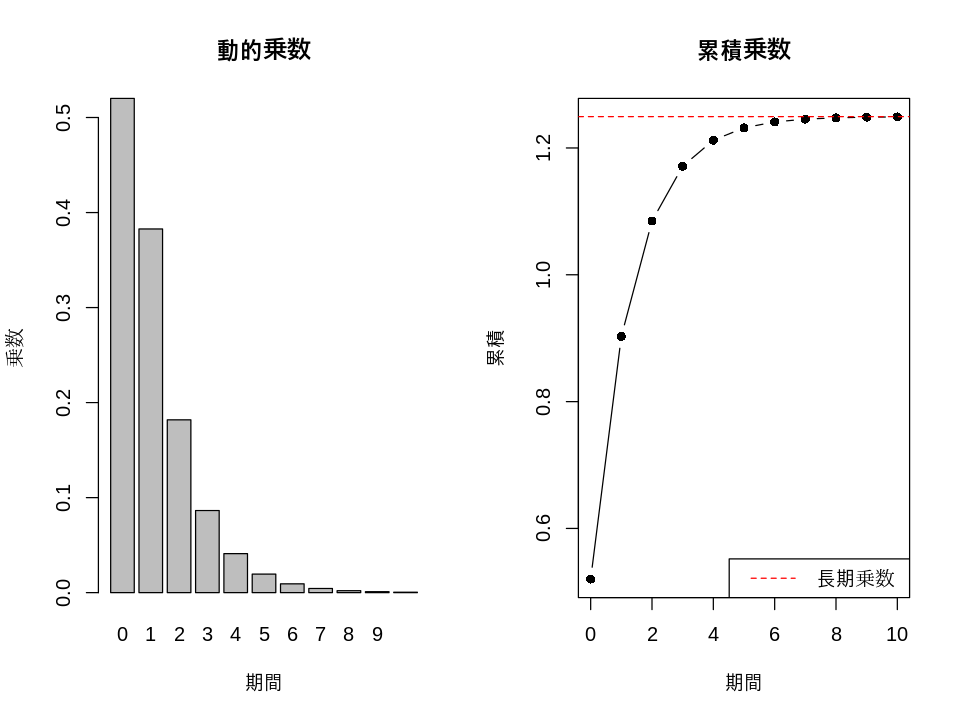

In [7]:
# データの生成
set.seed(789)
n <- 200
x <- rnorm(n)
y <- numeric(n)
y[1] <- rnorm(1)
for (t in 2:n) {
  y[t] <- 0.4 * y[t-1] + 0.5 * x[t] + 0.2 * x[t-1] + rnorm(1, 0, 0.5)
}
adl_data <- ts(cbind(y = y, x = x))

# 1. ADL(1,1)モデルの推定
adl_model <- dynlm(y ~ L(y, 1) + x + L(x, 1), data = adl_data)
cat("ADL(1,1)モデルの推定結果:\n")
summary(adl_model)

# 係数の抽出
rho <- coef(adl_model)["L(y, 1)"]
beta0 <- coef(adl_model)["x"]
beta1 <- coef(adl_model)["L(x, 1)"]

# 2. 衝撃乗数と長期乗数
impact_multiplier <- beta0
long_run_multiplier <- (beta0 + beta1) / (1 - rho)

cat("\n乗数:\n")
cat("衝撃乗数（即時効果）:", impact_multiplier, "\n")
cat("長期乗数:", long_run_multiplier, "\n")

cat("\n真の値:\n")
cat("衝撃乗数: 0.5\n")
cat("長期乗数: (0.5 + 0.2) / (1 - 0.4) =", (0.5 + 0.2) / (1 - 0.4), "\n")

# 3. 動的乗数の計算
horizons <- 10
dynamic_multiplier <- numeric(horizons + 1)
dynamic_multiplier[1] <- beta0  # h = 0
dynamic_multiplier[2] <- rho * beta0 + beta1  # h = 1

for (h in 3:(horizons + 1)) {
  dynamic_multiplier[h] <- rho * dynamic_multiplier[h - 1]
}

cumulative_multiplier <- cumsum(dynamic_multiplier)

# 結果の表示
cat("\n動的乗数:\n")
print(data.frame(
  期間 = 0:horizons,
  動的乗数 = round(dynamic_multiplier, 4),
  累積乗数 = round(cumulative_multiplier, 4)
))

# グラフ
par(mfrow = c(1, 2))
barplot(dynamic_multiplier, names.arg = 0:horizons, 
        main = "動的乗数", xlab = "期間", ylab = "乗数")
plot(0:horizons, cumulative_multiplier, type = "b", pch = 16,
     main = "累積乗数", xlab = "期間", ylab = "累積")
abline(h = long_run_multiplier, lty = 2, col = "red")
legend("bottomright", legend = "長期乗数", lty = 2, col = "red")
par(mfrow = c(1, 1))

---
## 問題4: 外生性の仮定

動的因果効果の推定には説明変数の外生性が重要です。

```r
set.seed(111)
n <- 200

# ケース1: xが厳密外生的
x1 <- rnorm(n)
e1 <- rnorm(n, 0, 0.5)
y1 <- numeric(n)
for (t in 2:n) {
  y1[t] <- 0.5 * x1[t] + 0.3 * x1[t-1] + e1[t]
}

# ケース2: xがyの過去に影響を受ける（厳密外生性の違反）
x2 <- numeric(n)
y2 <- numeric(n)
x2[1] <- rnorm(1)
y2[1] <- rnorm(1)
for (t in 2:n) {
  x2[t] <- 0.3 * y2[t-1] + rnorm(1)  # フィードバック
  y2[t] <- 0.5 * x2[t] + 0.3 * x2[t-1] + rnorm(1, 0, 0.5)
}
```

1. 両方のケースでDL(1)モデルを推定してください
2. 推定結果を比較し、バイアスがあるか確認してください
3. グレンジャー因果性検定を行ってください

In [8]:
# ここに回答を入力してください


### 模範解答

In [9]:
# データの生成
set.seed(111)
n <- 200

# ケース1: 厳密外生的
x1 <- rnorm(n)
e1 <- rnorm(n, 0, 0.5)
y1 <- numeric(n)
for (t in 2:n) {
  y1[t] <- 0.5 * x1[t] + 0.3 * x1[t-1] + e1[t]
}
data1 <- ts(cbind(y = y1, x = x1))

# ケース2: フィードバックあり
x2 <- numeric(n)
y2 <- numeric(n)
x2[1] <- rnorm(1)
y2[1] <- rnorm(1)
for (t in 2:n) {
  x2[t] <- 0.3 * y2[t-1] + rnorm(1)
  y2[t] <- 0.5 * x2[t] + 0.3 * x2[t-1] + rnorm(1, 0, 0.5)
}
data2 <- ts(cbind(y = y2, x = x2))

# 1. DL(1)モデルの推定
model1 <- dynlm(y ~ x + L(x, 1), data = data1)
model2 <- dynlm(y ~ x + L(x, 1), data = data2)

cat("ケース1（厳密外生）:\n")
print(coef(model1)[c("x", "L(x, 1)")])

cat("\nケース2（フィードバックあり）:\n")
print(coef(model2)[c("x", "L(x, 1)")])

# 2. 比較
cat("\n真の係数との比較:\n")
comparison <- data.frame(
  係数 = c("β0", "β1"),
  真の値 = c(0.5, 0.3),
  ケース1 = coef(model1)[c("x", "L(x, 1)")],
  ケース2 = coef(model2)[c("x", "L(x, 1)")]
)
print(comparison)

cat("\nケース2ではフィードバックによりバイアスが生じる可能性があります。\n")

# 3. グレンジャー因果性検定
cat("\nグレンジャー因果性検定（y → x）:\n")

# ケース1
granger1_full <- dynlm(x ~ L(x, 1:2) + L(y, 1:2), data = data1)
granger1_rest <- dynlm(x ~ L(x, 1:2), data = data1)
cat("ケース1:\n")
print(anova(granger1_rest, granger1_full))

# ケース2
granger2_full <- dynlm(x ~ L(x, 1:2) + L(y, 1:2), data = data2)
granger2_rest <- dynlm(x ~ L(x, 1:2), data = data2)
cat("\nケース2:\n")
print(anova(granger2_rest, granger2_full))

cat("\n解釈:\n")
cat("ケース2ではyからxへの因果関係が検出されます（厳密外生性の違反）。\n")

ケース1（厳密外生）:


        x   L(x, 1) 
0.4613361 0.3048252 



ケース2（フィードバックあり）:


        x   L(x, 1) 
0.4612506 0.2924904 



真の係数との比較:


        係数 真の値   ケース1   ケース2
x         β0    0.5 0.4613361 0.4612506
L(x, 1)   β1    0.3 0.3048252 0.2924904



ケース2ではフィードバックによりバイアスが生じる可能性があります。



グレンジャー因果性検定（y → x）:


ケース1:


Analysis of Variance Table

Model 1: x ~ L(x, 1:2)
Model 2: x ~ L(x, 1:2) + L(y, 1:2)
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1    195 213.34                           
2    193 209.02  2    4.3117 1.9906 0.1394



ケース2:


Analysis of Variance Table

Model 1: x ~ L(x, 1:2)
Model 2: x ~ L(x, 1:2) + L(y, 1:2)
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1    195 198.12                           
2    193 194.43  2     3.684 1.8284 0.1634



解釈:


ケース2ではyからxへの因果関係が検出されます（厳密外生性の違反）。


---
## 問題5: HAC標準誤差を使った推論

時系列データでは系列相関があるため、HAC標準誤差を使用します。

```r
set.seed(222)
n <- 150
x <- rnorm(n)
# 誤差項にAR(1)過程
e <- arima.sim(n = n, model = list(ar = 0.5), sd = 0.5)
y <- numeric(n)
for (t in 2:n) {
  y[t] <- 0.6 * x[t] + 0.4 * x[t-1] + e[t]
}
hac_data <- ts(cbind(y = y, x = x))
```

1. DL(1)モデルを推定してください
2. 通常の標準誤差とHAC標準誤差を比較してください
3. 長期乗数の標準誤差をデルタ法で計算してください

In [10]:
# ここに回答を入力してください


### 模範解答

In [11]:
# データの生成
set.seed(222)
n <- 150
x <- rnorm(n)
e <- arima.sim(n = n, model = list(ar = 0.5), sd = 0.5)
y <- numeric(n)
for (t in 2:n) {
  y[t] <- 0.6 * x[t] + 0.4 * x[t-1] + e[t]
}
hac_data <- ts(cbind(y = y, x = x))

# 1. DL(1)モデルの推定
dl1_model <- dynlm(y ~ x + L(x, 1), data = hac_data)
cat("DL(1)モデルの推定結果:\n")
summary(dl1_model)

# 2. 標準誤差の比較
cat("\n通常の標準誤差:\n")
print(coeftest(dl1_model))

cat("\nHAC標準誤差（Newey-West）:\n")
hac_test <- coeftest(dl1_model, vcov = NeweyWest(dl1_model))
print(hac_test)

# 比較表
se_comparison <- data.frame(
  係数 = names(coef(dl1_model)),
  通常SE = summary(dl1_model)$coefficients[, "Std. Error"],
  HAC_SE = hac_test[, "Std. Error"]
)
se_comparison$比率 <- se_comparison$HAC_SE / se_comparison$通常SE
cat("\n標準誤差の比較:\n")
print(se_comparison)

# 3. 長期乗数の標準誤差（デルタ法）
# DL(1)モデルでは長期乗数 = β0 + β1
beta <- coef(dl1_model)[c("x", "L(x, 1)")]
long_run <- sum(beta)

# HAC共分散行列
V_hac <- NeweyWest(dl1_model)[c("x", "L(x, 1)"), c("x", "L(x, 1)")]

# デルタ法: Var(β0 + β1) = Var(β0) + Var(β1) + 2*Cov(β0, β1)
gradient <- c(1, 1)  # ∂(β0 + β1)/∂β
se_long_run <- sqrt(t(gradient) %*% V_hac %*% gradient)

cat("\n長期乗数の推定:\n")
cat("推定値:", long_run, "\n")
cat("HAC標準誤差:", se_long_run, "\n")
cat("95%信頼区間:", long_run - 1.96 * se_long_run, "から", 
    long_run + 1.96 * se_long_run, "\n")
cat("\n真の長期乗数: 0.6 + 0.4 = 1.0\n")

DL(1)モデルの推定結果:



Time series regression with "ts" data:
Start = 2, End = 150

Call:
dynlm(formula = y ~ x + L(x, 1), data = hac_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.34088 -0.38593 -0.04605  0.35878  1.73742 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.07530    0.04316  -1.745   0.0832 .  
x            0.64579    0.04432  14.571   <2e-16 ***
L(x, 1)      0.45339    0.04405  10.292   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5263 on 146 degrees of freedom
Multiple R-squared:  0.6978,	Adjusted R-squared:  0.6936 
F-statistic: 168.5 on 2 and 146 DF,  p-value: < 2.2e-16



通常の標準誤差:



t test of coefficients:

             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.075301   0.043163 -1.7446  0.08317 .  
x            0.645788   0.044321 14.5706  < 2e-16 ***
L(x, 1)      0.453392   0.044054 10.2918  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




HAC標準誤差（Newey-West）:



t test of coefficients:

             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.075301   0.065388 -1.1516   0.2514    
x            0.645788   0.047767 13.5196   <2e-16 ***
L(x, 1)      0.453392   0.046611  9.7271   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




標準誤差の比較:


                   係数     通常SE     HAC_SE     比率
(Intercept) (Intercept) 0.04316347 0.06538783 1.514888
x                     x 0.04432125 0.04776686 1.077742
L(x, 1)         L(x, 1) 0.04405369 0.04661130 1.058057



長期乗数の推定:


推定値: 1.099181 


HAC標準誤差: 0.08510576 


95%信頼区間: 0.9323734 から 1.265988 



真の長期乗数: 0.6 + 0.4 = 1.0


---
## 問題6: オレンジジュースと凍結気温

フロリダの凍結気温がオレンジジュース価格に与える動的影響を分析します。

以下のシミュレーションデータを使います。

```r
set.seed(333)
n <- 120  # 10年間の月次データ
# 凍結日数（冬に多い）
month <- rep(1:12, 10)
freeze <- ifelse(month %in% c(12, 1, 2, 3), rpois(n, 3), rpois(n, 0.1))
freeze <- freeze[1:n]

# 価格変化（凍結の影響は0-2期まで）
price_change <- numeric(n)
for (t in 3:n) {
  price_change[t] <- 2 * freeze[t] + 1.5 * freeze[t-1] + 0.5 * freeze[t-2] + rnorm(1, 0, 3)
}
oj_data <- ts(cbind(price_change = price_change, freeze = freeze), frequency = 12)
```

1. データの時系列プロットを作成してください
2. DL(4)モデルを推定してください
3. 凍結による価格への累積効果を計算してください

In [12]:
# ここに回答を入力してください


### 模範解答

Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <b5>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '凍結日数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <99>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '日数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '日数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '日数' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '日数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '日数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '日数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <a1>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <a0>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <8c>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格変化' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <99>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <93>”


DL(4)モデルの推定結果:



Time series regression with "ts" data:
Start = 1(5), End = 10(12)

Call:
dynlm(formula = price_change ~ freeze + L(freeze, 1) + L(freeze, 
    2) + L(freeze, 3) + L(freeze, 4), data = oj_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7311 -2.1923  0.0982  2.1362  7.5735 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.84925    0.44258   1.919  0.05759 .  
freeze        1.67098    0.19471   8.582 6.77e-14 ***
L(freeze, 1)  1.26818    0.19307   6.568 1.75e-09 ***
L(freeze, 2)  0.49844    0.18527   2.690  0.00825 ** 
L(freeze, 3) -0.07525    0.17999  -0.418  0.67668    
L(freeze, 4) -0.03431    0.18395  -0.186  0.85240    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.043 on 110 degrees of freedom
Multiple R-squared:  0.699,	Adjusted R-squared:  0.6853 
F-statistic:  51.1 on 5 and 110 DF,  p-value: < 2.2e-16



HAC標準誤差を使用した結果:



t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)   0.849254   0.535021  1.5873  0.115309    
freeze        1.670984   0.160231 10.4286 < 2.2e-16 ***
L(freeze, 1)  1.268183   0.132194  9.5934 3.349e-16 ***
L(freeze, 2)  0.498437   0.185705  2.6840  0.008399 ** 
L(freeze, 3) -0.075254   0.186131 -0.4043  0.686771    
L(freeze, 4) -0.034306   0.159282 -0.2154  0.829871    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




累積効果:


             ラグ 動的乗数 累積乗数
freeze          0    1.671    1.671
L(freeze, 1)    1    1.268    2.939
L(freeze, 2)    2    0.498    3.438
L(freeze, 3)    3   -0.075    3.362
L(freeze, 4)    4   -0.034    3.328


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <9a>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <84>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '動的乗数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <a1>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <a0>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <b1>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <bf>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '価格への影響（%）' in 'mbcsToSbcs': dot substituted for <89>”


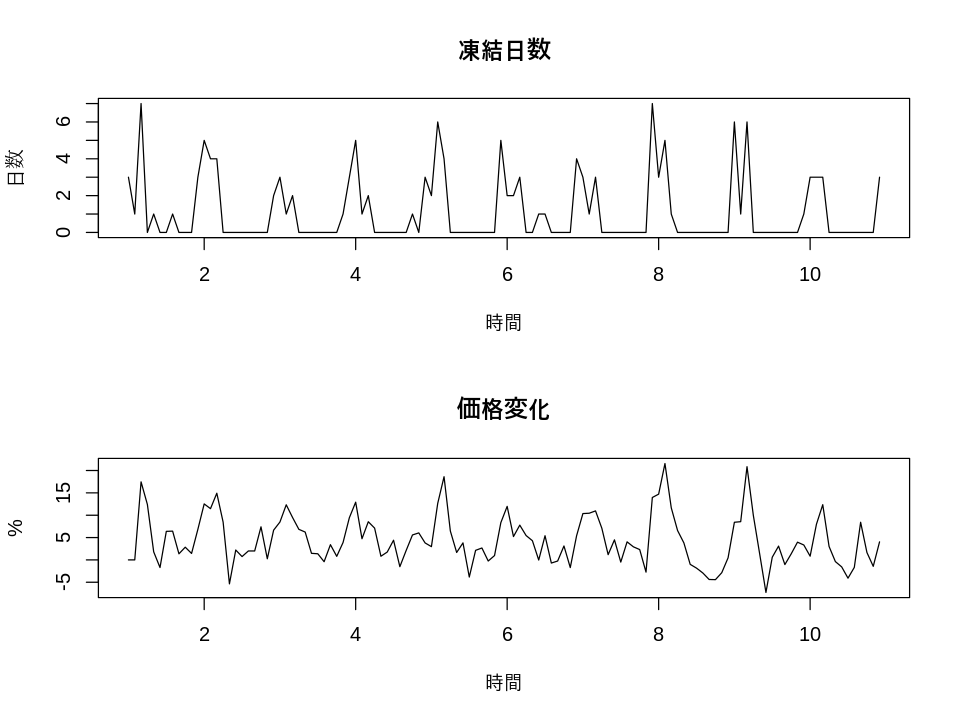

Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <b4>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(...):
“conversion failure on '累積乗数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(...):
“conversion failure on 'ラグ（月）' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <b4>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <9e>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(...):
“conversion failure on '累積効果（%）' in 'mbcsToSbcs': dot substituted for <89>”



解釈:


凍結日数が1日増えると、価格は即座に約 1.67 %上昇し、


2ヶ月後までの累積効果は約 3.44 %になります。


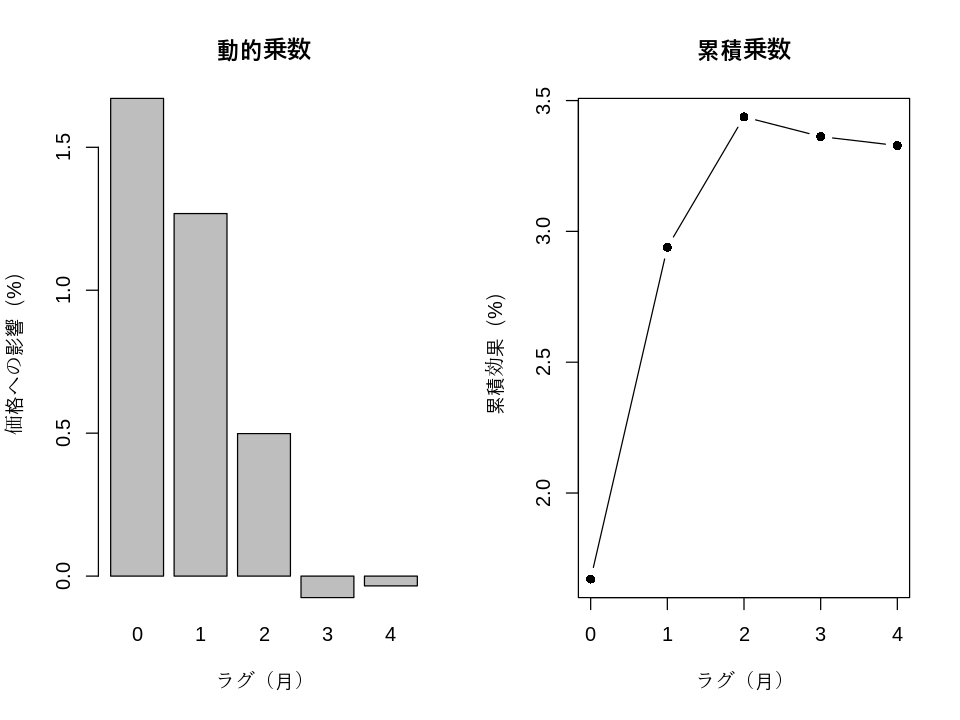

In [13]:
# データの生成
set.seed(333)
n <- 120
month <- rep(1:12, 10)
freeze <- ifelse(month %in% c(12, 1, 2, 3), rpois(n, 3), rpois(n, 0.1))
freeze <- freeze[1:n]

price_change <- numeric(n)
for (t in 3:n) {
  price_change[t] <- 2 * freeze[t] + 1.5 * freeze[t-1] + 0.5 * freeze[t-2] + rnorm(1, 0, 3)
}
oj_data <- ts(cbind(price_change = price_change, freeze = freeze), frequency = 12)

# 1. 時系列プロット
par(mfrow = c(2, 1))
plot(oj_data[, "freeze"], main = "凍結日数", ylab = "日数", xlab = "時間")
plot(oj_data[, "price_change"], main = "価格変化", ylab = "%", xlab = "時間")
par(mfrow = c(1, 1))

# 2. DL(4)モデルの推定
dl4_oj <- dynlm(price_change ~ freeze + L(freeze, 1) + L(freeze, 2) + 
                L(freeze, 3) + L(freeze, 4), data = oj_data)
cat("DL(4)モデルの推定結果:\n")
summary(dl4_oj)

# HAC標準誤差
cat("\nHAC標準誤差を使用した結果:\n")
print(coeftest(dl4_oj, vcov = NeweyWest(dl4_oj)))

# 3. 累積効果の計算
coefs <- coef(dl4_oj)[c("freeze", "L(freeze, 1)", "L(freeze, 2)", 
                        "L(freeze, 3)", "L(freeze, 4)")]
cumulative <- cumsum(coefs)

cat("\n累積効果:\n")
print(data.frame(
  ラグ = 0:4,
  動的乗数 = round(coefs, 3),
  累積乗数 = round(cumulative, 3)
))

# グラフ
par(mfrow = c(1, 2))
barplot(coefs, names.arg = 0:4, main = "動的乗数", 
        xlab = "ラグ（月）", ylab = "価格への影響（%）")
plot(0:4, cumulative, type = "b", pch = 16, main = "累積乗数",
     xlab = "ラグ（月）", ylab = "累積効果（%）")
par(mfrow = c(1, 1))

cat("\n解釈:\n")
cat("凍結日数が1日増えると、価格は即座に約", round(coefs[1], 2), "%上昇し、\n")
cat("2ヶ月後までの累積効果は約", round(cumulative[3], 2), "%になります。\n")

---
## 問題7: 金融政策の効果

金利変更がインフレ率に与える動的効果を分析します。

```r
set.seed(444)
n <- 160  # 40年間の四半期データ

# 金利変更（外生的なショック）
rate_change <- rnorm(n, 0, 0.5)

# インフレ率（金利上昇は遅れてインフレを抑制）
inflation <- numeric(n)
inflation[1:4] <- rnorm(4, 2, 0.5)
for (t in 5:n) {
  inflation[t] <- 0.7 * inflation[t-1] - 0.2 * rate_change[t-2] - 
                  0.3 * rate_change[t-3] - 0.2 * rate_change[t-4] + 
                  rnorm(1, 0, 0.3)
}
macro_data <- ts(cbind(inflation = inflation, rate = rate_change), frequency = 4)
```

1. ADL(1,4)モデルを推定してください
2. インパルス応答関数を計算してください
3. 金利1%上昇の累積効果を推定してください

In [14]:
# ここに回答を入力してください


### 模範解答

ADL(1,4)モデルの推定結果:



Time series regression with "ts" data:
Start = 2(1), End = 40(4)

Call:
dynlm(formula = inflation ~ L(inflation, 1) + rate + L(rate, 
    1:4), data = macro_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.07509 -0.18070 -0.00039  0.21207  0.69248 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.008049   0.024554  -0.328 0.743519    
L(inflation, 1)  0.693687   0.042668  16.258  < 2e-16 ***
rate             0.026807   0.050542   0.530 0.596627    
L(rate, 1:4)1   -0.053517   0.049172  -1.088 0.278188    
L(rate, 1:4)2   -0.188354   0.048668  -3.870 0.000162 ***
L(rate, 1:4)3   -0.295078   0.050023  -5.899 2.36e-08 ***
L(rate, 1:4)4   -0.237314   0.054581  -4.348 2.53e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3062 on 149 degrees of freedom
Multiple R-squared:  0.7714,	Adjusted R-squared:  0.7622 
F-statistic: 83.81 on 6 and 149 DF,  p-value: < 2.2e-16



インパルス応答関数（最初の10期）:


   期間     IRF 累積IRF
1     0  0.0268  0.0268
2     1 -0.0535 -0.0267
3     2 -0.1884 -0.2151
4     3 -0.2951 -0.5101
5     4 -0.2373 -0.7475
6     5 -0.1646 -0.9121
7     6 -0.1142 -1.0263
8     7 -0.0792 -1.1055
9     8 -0.0550 -1.1604
10    9 -0.0381 -1.1986
11   10 -0.0264 -1.2250



長期累積効果: -2.4402 


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <91>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <bf>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <94>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(...):
“conversion failure on 'インパルス応答関数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <9b>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <9b>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <ac>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <b1>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(...):
“conversion failure on 'インフレ率への影響' in 'mbcsToSbcs': dot substituted for <bf>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <b4>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <91>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <bf>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in title(...):
“conversion failure on '累積インパルス応答' in 'mbcsToSbcs': dot substituted for <94>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <9b>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <9b>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on '四半期' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <b4>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <9e>”


Warning message in title(...):
“conversion failure on '累積効果' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <9e>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <9e>”


Warning message in text.default(x, y, ...):
“conversion failure on '長期効果' in 'mbcsToSbcs': dot substituted for <9c>”



解釈:


金利1%の上昇は、即座にはインフレに影響を与えませんが、


2-4四半期後にインフレを低下させ、長期的には約 -2.44 %の低下をもたらします。


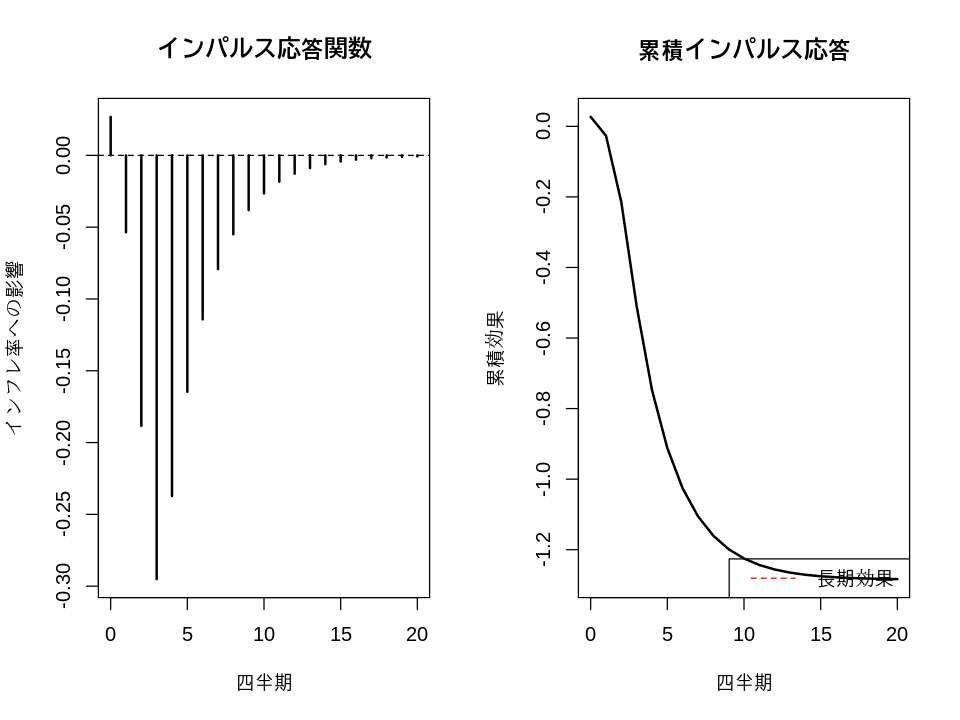

In [15]:
# データの生成
set.seed(444)
n <- 160
rate_change <- rnorm(n, 0, 0.5)

inflation <- numeric(n)
inflation[1:4] <- rnorm(4, 2, 0.5)
for (t in 5:n) {
  inflation[t] <- 0.7 * inflation[t-1] - 0.2 * rate_change[t-2] - 
                  0.3 * rate_change[t-3] - 0.2 * rate_change[t-4] + 
                  rnorm(1, 0, 0.3)
}
macro_data <- ts(cbind(inflation = inflation, rate = rate_change), frequency = 4)

# 1. ADL(1,4)モデルの推定
adl_macro <- dynlm(inflation ~ L(inflation, 1) + rate + L(rate, 1:4), data = macro_data)
cat("ADL(1,4)モデルの推定結果:\n")
summary(adl_macro)

# 係数の抽出
rho <- coef(adl_macro)["L(inflation, 1)"]
beta <- coef(adl_macro)[c("rate", "L(rate, 1:4)1", "L(rate, 1:4)2", 
                          "L(rate, 1:4)3", "L(rate, 1:4)4")]

# 2. インパルス応答関数の計算
horizons <- 20
irf <- numeric(horizons + 1)

# 最初の5期はβ係数
for (h in 0:4) {
  irf[h + 1] <- beta[h + 1]
}

# それ以降はρによる減衰
for (h in 5:horizons) {
  irf[h + 1] <- rho * irf[h]  # h-1期の応答 × ρ
}

# 累積応答
cumulative_irf <- cumsum(irf)

# 結果の表示
cat("\nインパルス応答関数（最初の10期）:\n")
print(data.frame(
  期間 = 0:10,
  IRF = round(irf[1:11], 4),
  累積IRF = round(cumulative_irf[1:11], 4)
))

# 3. 長期累積効果
long_run_effect <- sum(beta) / (1 - rho)
cat("\n長期累積効果:", round(long_run_effect, 4), "\n")

# グラフ
par(mfrow = c(1, 2))
plot(0:horizons, irf, type = "h", lwd = 2, main = "インパルス応答関数",
     xlab = "四半期", ylab = "インフレ率への影響")
abline(h = 0, lty = 2)

plot(0:horizons, cumulative_irf, type = "l", lwd = 2, main = "累積インパルス応答",
     xlab = "四半期", ylab = "累積効果")
abline(h = long_run_effect, lty = 2, col = "red")
legend("bottomright", legend = "長期効果", lty = 2, col = "red")
par(mfrow = c(1, 1))

cat("\n解釈:\n")
cat("金利1%の上昇は、即座にはインフレに影響を与えませんが、\n")
cat("2-4四半期後にインフレを低下させ、長期的には約", 
    round(long_run_effect, 2), "%の低下をもたらします。\n")

---
## 問題8: VARモデルによる動的分析

複数の変数間の動的関係をVAR（Vector Autoregression）モデルで分析します。

```r
set.seed(555)
n <- 200

# 2変数VARシステム
y1 <- numeric(n)
y2 <- numeric(n)
y1[1] <- rnorm(1)
y2[1] <- rnorm(1)

for (t in 2:n) {
  y1[t] <- 0.5 * y1[t-1] + 0.2 * y2[t-1] + rnorm(1, 0, 0.5)
  y2[t] <- 0.3 * y1[t-1] + 0.4 * y2[t-1] + rnorm(1, 0, 0.5)
}

var_data <- cbind(y1 = y1, y2 = y2)
```

1. VAR(1)モデルを推定してください
2. グレンジャー因果性を検定してください
3. インパルス応答関数を計算してください

In [16]:
# ここに回答を入力してください


### 模範解答

VAR(1)モデルの推定結果:



VAR Estimation Results:
Endogenous variables: y1, y2 
Deterministic variables: const 
Sample size: 199 
Log Likelihood: -297.893 
Roots of the characteristic polynomial:
0.6616 0.2317
Call:
VAR(y = var_data, p = 1)


Estimation results for equation y1: 
y1 = y1.l1 + y2.l1 + const 

      Estimate Std. Error t value Pr(>|t|)    
y1.l1  0.51902    0.05940   8.738 1.06e-15 ***
y2.l1  0.18452    0.06680   2.762  0.00629 ** 
const  0.01633    0.03771   0.433  0.66540    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.5308 on 196 degrees of freedom
Multiple R-Squared: 0.3182,	Adjusted R-squared: 0.3113 
F-statistic: 45.74 on 2 and 196 DF,  p-value: < 2.2e-16 


Estimation results for equation y2: 
y2 = y1.l1 + y2.l1 + const 

       Estimate Std. Error t value Pr(>|t|)    
y1.l1  0.221952   0.056458   3.931 0.000117 ***
y2.l1  0.374249   0.063490   5.895 1.62e-08 ***
const -0.001247   0.035842  -0.035 0.972290    
---
Signif. codes:  0 ‘***’ 


係数行列:


   y1.l1 y2.l1
y1 0.519 0.185
y2 0.222 0.374



真の係数行列:


   y1.l1 y2.l1
y1   0.5   0.3
y2   0.2   0.4



グレンジャー因果性検定:



y2 → y1（y2がy1をグレンジャー因果するか）:



	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object var_model
F-Test = 7.6305, df1 = 1, df2 = 392, p-value = 0.006009




y1 → y2（y1がy2をグレンジャー因果するか）:



	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object var_model
F-Test = 15.455, df1 = 1, df2 = 392, p-value = 9.99e-05



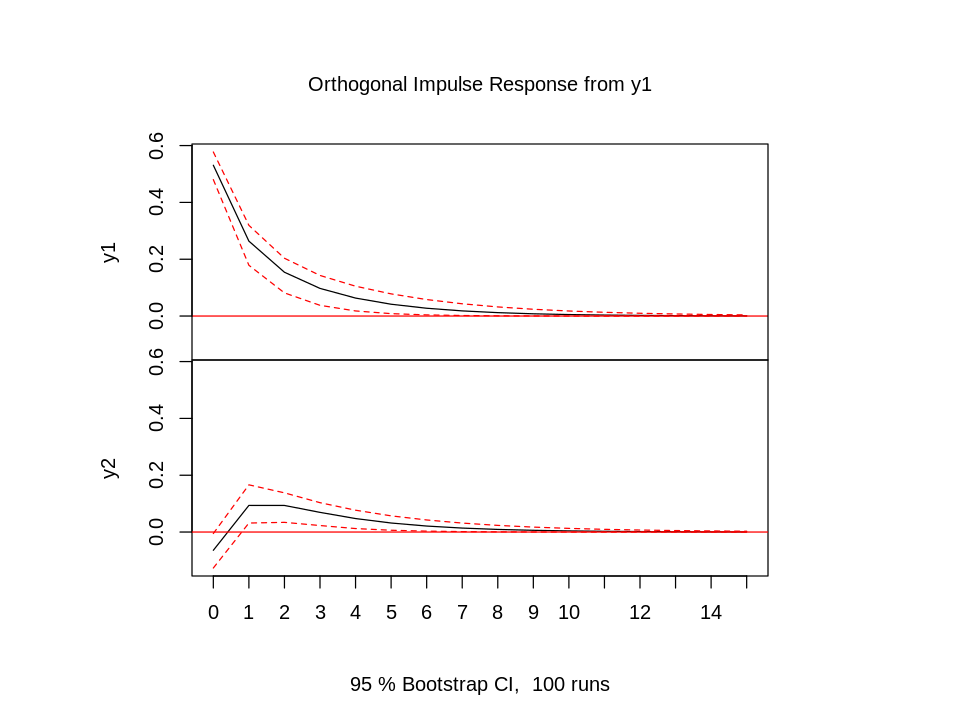


解釈:


両方向のグレンジャー因果関係が検出されます。


y1とy2は相互に影響を与え合っています。


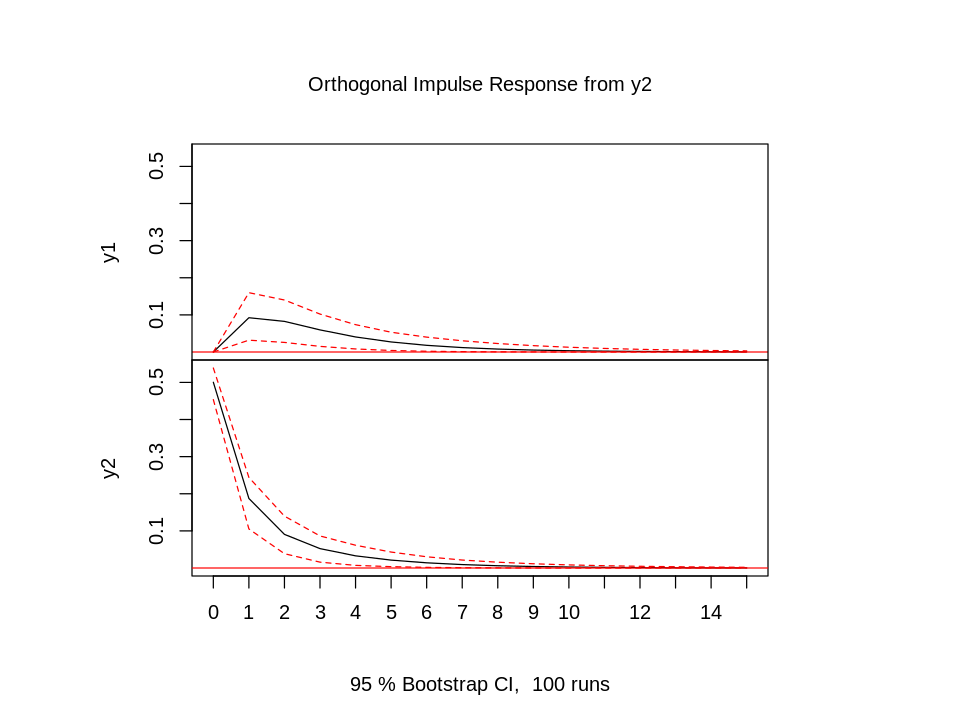

In [17]:
# データの生成
set.seed(555)
n <- 200

y1 <- numeric(n)
y2 <- numeric(n)
y1[1] <- rnorm(1)
y2[1] <- rnorm(1)

for (t in 2:n) {
  y1[t] <- 0.5 * y1[t-1] + 0.2 * y2[t-1] + rnorm(1, 0, 0.5)
  y2[t] <- 0.3 * y1[t-1] + 0.4 * y2[t-1] + rnorm(1, 0, 0.5)
}

var_data <- cbind(y1 = y1, y2 = y2)

# 1. VAR(1)モデルの推定
var_model <- VAR(var_data, p = 1)
cat("VAR(1)モデルの推定結果:\n")
summary(var_model)

# 係数行列の抽出
cat("\n係数行列:\n")
coef_matrix <- rbind(
  coef(var_model$varresult$y1)[1:2],
  coef(var_model$varresult$y2)[1:2]
)
rownames(coef_matrix) <- c("y1", "y2")
colnames(coef_matrix) <- c("y1.l1", "y2.l1")
print(round(coef_matrix, 3))

cat("\n真の係数行列:\n")
print(matrix(c(0.5, 0.3, 0.2, 0.4), nrow = 2, byrow = TRUE,
             dimnames = list(c("y1", "y2"), c("y1.l1", "y2.l1"))))

# 2. グレンジャー因果性検定
cat("\nグレンジャー因果性検定:\n")
cat("\ny2 → y1（y2がy1をグレンジャー因果するか）:\n")
print(causality(var_model, cause = "y2")$Granger)

cat("\ny1 → y2（y1がy2をグレンジャー因果するか）:\n")
print(causality(var_model, cause = "y1")$Granger)

# 3. インパルス応答関数
irf_results <- irf(var_model, n.ahead = 15, boot = TRUE, ci = 0.95)

# プロット
plot(irf_results)

cat("\n解釈:\n")
cat("両方向のグレンジャー因果関係が検出されます。\n")
cat("y1とy2は相互に影響を与え合っています。\n")

---
## 問題9: 予測誤差分散分解

VARモデルを使って、各変数の変動がどの程度他の変数のショックで説明されるかを分析します。

問題8のデータを使って：

1. 予測誤差分散分解を計算してください
2. 各時点での分散の構成を確認してください
3. 結果を解釈してください

In [18]:
# ここに回答を入力してください


### 模範解答

y1の予測誤差分散分解:


          y1     y2
 [1,] 1.0000 0.0000
 [2,] 0.9763 0.0237
 [3,] 0.9607 0.0393
 [4,] 0.9532 0.0468
 [5,] 0.9498 0.0502
 [6,] 0.9484 0.0516
 [7,] 0.9477 0.0523
 [8,] 0.9474 0.0526
 [9,] 0.9473 0.0527
[10,] 0.9473 0.0527
[11,] 0.9472 0.0528
[12,] 0.9472 0.0528
[13,] 0.9472 0.0528
[14,] 0.9472 0.0528
[15,] 0.9472 0.0528



y2の予測誤差分散分解:


          y1     y2
 [1,] 0.0162 0.9838
 [2,] 0.0433 0.9567
 [3,] 0.0687 0.9313
 [4,] 0.0820 0.9180
 [5,] 0.0881 0.9119
 [6,] 0.0908 0.9092
 [7,] 0.0920 0.9080
 [8,] 0.0925 0.9075
 [9,] 0.0927 0.9073
[10,] 0.0928 0.9072
[11,] 0.0928 0.9072
[12,] 0.0929 0.9071
[13,] 0.0929 0.9071
[14,] 0.0929 0.9071
[15,] 0.0929 0.9071



解釈:


y1の変動:


- 短期では主に自身のショックで説明される


- 時間が経つとy2のショックの寄与も増加


- 長期ではy2のショックが約 5.3 %を説明



y2の変動:


- y1のショックが比較的大きな影響を持つ


- 長期ではy1のショックが約 9.3 %を説明


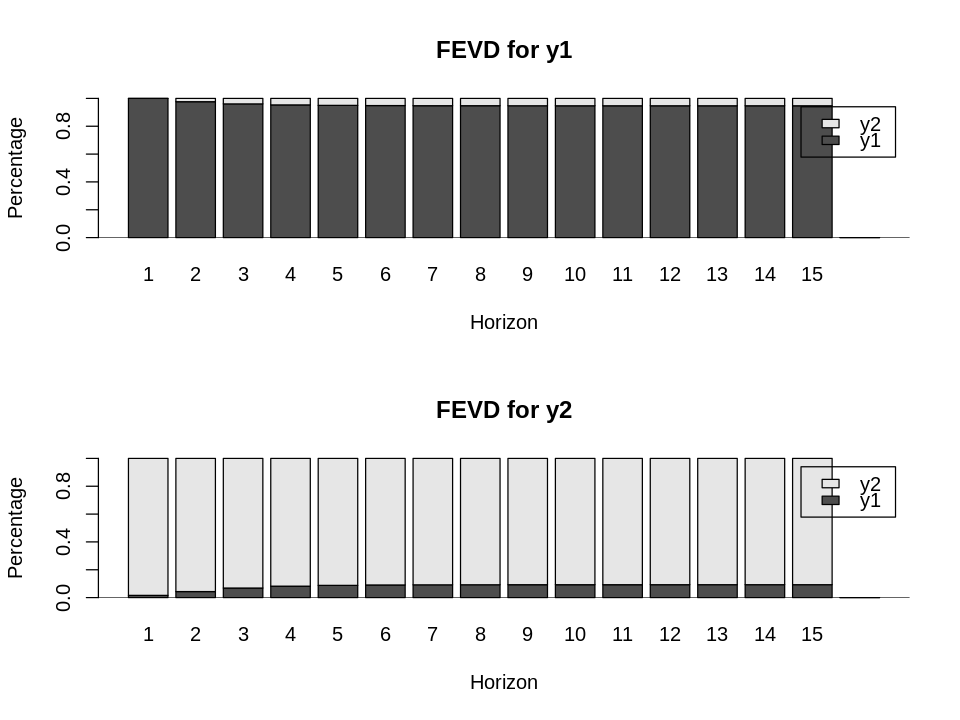

In [19]:
# 問題8のデータとモデルを再利用
set.seed(555)
n <- 200

y1 <- numeric(n)
y2 <- numeric(n)
y1[1] <- rnorm(1)
y2[1] <- rnorm(1)

for (t in 2:n) {
  y1[t] <- 0.5 * y1[t-1] + 0.2 * y2[t-1] + rnorm(1, 0, 0.5)
  y2[t] <- 0.3 * y1[t-1] + 0.4 * y2[t-1] + rnorm(1, 0, 0.5)
}

var_data <- cbind(y1 = y1, y2 = y2)
var_model <- VAR(var_data, p = 1)

# 1. 予測誤差分散分解
fevd_results <- fevd(var_model, n.ahead = 15)

# 2. 結果の表示
cat("y1の予測誤差分散分解:\n")
print(round(fevd_results$y1, 4))

cat("\ny2の予測誤差分散分解:\n")
print(round(fevd_results$y2, 4))

# グラフ
plot(fevd_results)

# 3. 解釈
cat("\n解釈:\n")
cat("y1の変動:\n")
cat("- 短期では主に自身のショックで説明される\n")
cat("- 時間が経つとy2のショックの寄与も増加\n")
cat("- 長期ではy2のショックが約", 
    round(fevd_results$y1[15, "y2"] * 100, 1), "%を説明\n\n")

cat("y2の変動:\n")
cat("- y1のショックが比較的大きな影響を持つ\n")
cat("- 長期ではy1のショックが約", 
    round(fevd_results$y2[15, "y1"] * 100, 1), "%を説明\n")

---
## 問題10: 実データでの動的因果効果の推定

USMacroGデータを使って、金利とインフレの動的関係を分析します。

1. データを読み込み、インフレ率と3ヶ月国債金利を取得してください
2. VARモデルの最適なラグ次数を選択してください
3. グレンジャー因果性検定とインパルス応答を分析してください

In [20]:
# ここに回答を入力してください


### 模範解答

Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <ac>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <b4>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'インフレ率（年率）' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <b6>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <9b>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <b5>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <91>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '3ヶ月国債金利' in 'mbcsToSbcs': dot substituted for <a9>”


ラグ次数選択基準:


AIC(n)  HQ(n)  SC(n) FPE(n) 
     8      4      4      8 


               1         2         3         4         5         6         7
AIC(n) 0.9998435 0.8435613 0.7055965 0.5648534 0.5912308 0.5791524 0.5531663
HQ(n)  1.0406189 0.9115202 0.8007390 0.6871794 0.7407404 0.7558456 0.7570430
SC(n)  1.1005512 1.0114075 0.9405811 0.8669764 0.9604922 1.0155524 1.0567047
FPE(n) 2.7178697 2.3246833 2.0251793 1.7594207 1.8066432 1.7852323 1.7398090
               8
AIC(n) 0.5378465
HQ(n)  0.7689068
SC(n)  1.1085234
FPE(n) 1.7138358



VAR(4)モデルの推定結果:



VAR Estimation Results:
Endogenous variables: inflation, tbill 
Deterministic variables: const 
Sample size: 199 
Log Likelihood: -614.14 
Roots of the characteristic polynomial:
0.9143 0.9143 0.7026 0.7026 0.669 0.669 0.5957 0.5314
Call:
VAR(y = macro_ts, p = optimal_lag)


Estimation results for equation inflation: 
inflation = inflation.l1 + tbill.l1 + inflation.l2 + tbill.l2 + inflation.l3 + tbill.l3 + inflation.l4 + tbill.l4 + const 

             Estimate Std. Error t value Pr(>|t|)    
inflation.l1  0.15103    0.07109   2.125 0.034921 *  
tbill.l1      1.27788    0.22951   5.568  8.7e-08 ***
inflation.l2  0.12441    0.07027   1.770 0.078270 .  
tbill.l2     -1.21589    0.35462  -3.429 0.000744 ***
inflation.l3  0.18668    0.07037   2.653 0.008661 ** 
tbill.l3      0.76330    0.36178   2.110 0.036179 *  
inflation.l4  0.22668    0.06939   3.267 0.001291 ** 
tbill.l4     -0.66021    0.23139  -2.853 0.004806 ** 
const         0.20899    0.32216   0.649 0.517306    
---
Signif. cod


グレンジャー因果性検定:



金利 → インフレ:



	Granger causality H0: tbill do not Granger-cause inflation

data:  VAR object var_macro
F-Test = 8.8184, df1 = 4, df2 = 380, p-value = 8.116e-07




インフレ → 金利:



	Granger causality H0: inflation do not Granger-cause tbill

data:  VAR object var_macro
F-Test = 2.5146, df1 = 4, df2 = 380, p-value = 0.04122



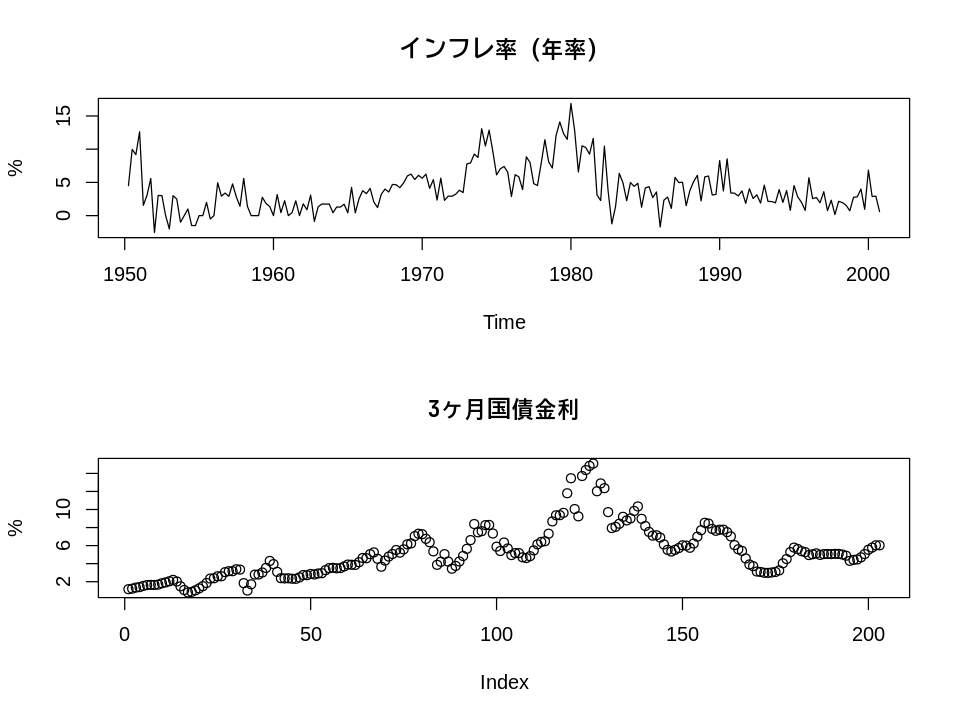

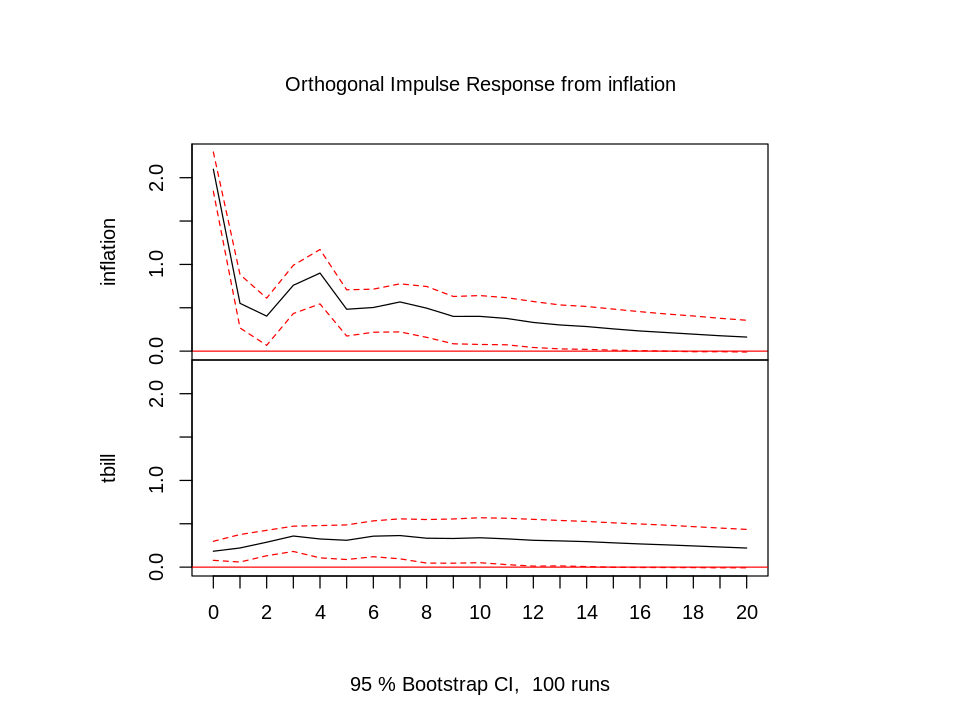


解釈:


- 金利とインフレの間には双方向の因果関係が存在する可能性


- 金利の上昇はインフレを抑制する効果がある（数四半期のラグを伴う）


- インフレの上昇は金利の引き上げにつながる（中央銀行の反応）


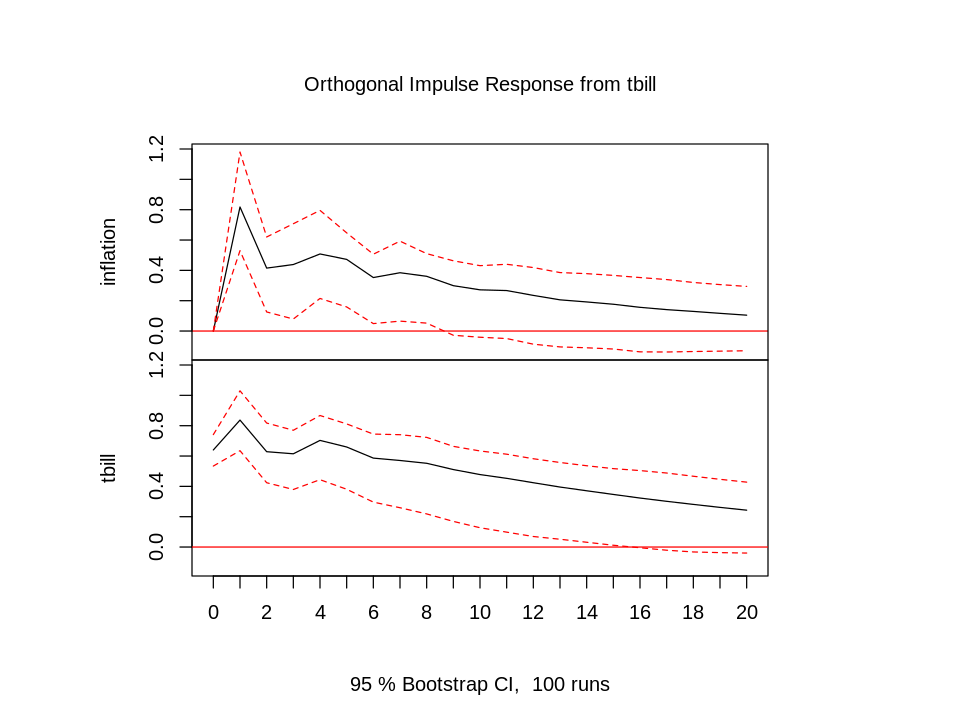

In [21]:
# 1. データの読み込みと準備
data("USMacroG")

# インフレ率（CPIの対数差分）と3ヶ月国債金利
inflation <- diff(log(USMacroG[, "cpi"])) * 400  # 年率換算
tbill <- USMacroG[-1, "tbill"]  # 差分を取ったのでサイズを合わせる

macro_ts <- cbind(inflation = as.numeric(inflation), tbill = as.numeric(tbill))
macro_ts <- macro_ts[complete.cases(macro_ts), ]

# データの確認
par(mfrow = c(2, 1))
plot(inflation, main = "インフレ率（年率）", ylab = "%")
plot(tbill, main = "3ヶ月国債金利", ylab = "%")
par(mfrow = c(1, 1))

# 2. ラグ次数の選択
lag_select <- VARselect(macro_ts, lag.max = 8)
cat("ラグ次数選択基準:\n")
print(lag_select$selection)
print(lag_select$criteria)

# 選択されたラグでVARを推定
optimal_lag <- lag_select$selection["SC(n)"]  # BIC基準
var_macro <- VAR(macro_ts, p = optimal_lag)

cat("\nVAR(", optimal_lag, ")モデルの推定結果:\n", sep = "")
summary(var_macro)

# 3. グレンジャー因果性検定
cat("\nグレンジャー因果性検定:\n")
cat("\n金利 → インフレ:\n")
print(causality(var_macro, cause = "tbill")$Granger)

cat("\nインフレ → 金利:\n")
print(causality(var_macro, cause = "inflation")$Granger)

# インパルス応答
irf_macro <- irf(var_macro, n.ahead = 20, boot = TRUE, ci = 0.95)
plot(irf_macro)

cat("\n解釈:\n")
cat("- 金利とインフレの間には双方向の因果関係が存在する可能性\n")
cat("- 金利の上昇はインフレを抑制する効果がある（数四半期のラグを伴う）\n")
cat("- インフレの上昇は金利の引き上げにつながる（中央銀行の反応）\n")

---
## まとめ

この章では以下の内容を学びました：

1. **動的因果効果**: 政策変更の効果が時間を通じて広がる現象
2. **分布ラグモデル（DL）**: 説明変数の過去の値の効果を推定
3. **ADLモデル**: 被説明変数のラグも含めたモデル
4. **乗数の計算**: 衝撃乗数、動的乗数、累積乗数、長期乗数
5. **外生性の仮定**: 厳密外生性とその検定
6. **HAC標準誤差**: 系列相関に頑健な推論
7. **VARモデル**: 複数変数間の動的関係の分析
8. **インパルス応答関数**: ショックの伝播の可視化
9. **予測誤差分散分解**: 変動の源泉の分析